In [1]:
import os
import pathlib
import random
import glob
import math
import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import SimpleITK as sitk

from skimage import color, io, img_as_ubyte, img_as_float, segmentation, measure
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, EuclideanTransform, SimilarityTransform, warp, swirl, matrix_transform 
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening
from skimage.color import label2rgb, rgb2gray
from skimage.filters import median, gaussian, prewitt_h, prewitt_v, prewitt, threshold_otsu

from sklearn import decomposition
from sklearn.decomposition import PCA

from scipy.ndimage import correlate
from scipy.stats import norm
from scipy.spatial import distance

from LDA import LDA

## Image Tracing

In [2]:
def index(array, item):
    # array is 1-dimensional
    # returns index of first instance of item
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]

def image_tracing(img):
    acc_img = np.zeros(img.shape)
    trace_img = np.zeros(img.shape)

    # initialise first row of accumulator image
    acc_img[0,:] = img[0,:]

    for row in range(1,img.shape[0]):
        for col in range(img.shape[1]):
            # follow 0-indexing
            min_col = max(0,col-1)
            max_col = min(img.shape[1]-1,col+1)
            min_pixel = min(acc_img[row-1,min_col],acc_img[row-1,col],acc_img[row-1,max_col])
            acc_img[row,col] = img[row,col]+min_pixel

            # change to 1-indexing
            idx = index(acc_img[row-1,:],min_pixel)
            idx = idx+1
            trace_img[row,col] = idx
    
    print("input image: \n", img)
    print("accumulator image: \n", acc_img)
    print("trace image: \n", trace_img)
    
    return acc_img, trace_img


In [3]:
# From https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html
def plot_comparison(original, filtered, filter_name):
    """
    convenience function to show two images side by side:
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

In [4]:
# img = np.array([[177,195,181,30,192],
#                 [81,203,192,127,65],
#                 [242,48,70,245,129],
#                 [9,125,173,87,178],
#                 [112,114,167,149,227]])

# img = np.array([[],
#                 [],
#                 [],
#                 [],
#                 []])

# acc_img, trace_img = image_tracing(img)

In [5]:
in_dir = "spring2023_data/"

## Glass PCA

In [6]:
txt_name = "glass_data.txt"
x = np.loadtxt(in_dir + txt_name, comments="%")

# Check matric dimensions
n_feat = x.shape[1]   # columns
n_obs = x.shape[0]    # rows
print(f"No. of features: {n_feat}")
print(f"No. of observations: {n_obs}")

No. of features: 9
No. of observations: 214


In [7]:
mean_ms = x.mean(axis=0)   # compute mean of each col
print(mean_ms.shape)
x = x-mean_ms

(9,)


In [8]:
mu_x = np.mean(x, axis=0)

# subtract mean and normalise
for i in range(n_feat):
    min_ms = min(x[:,i])
    max_ms = max(x[:,i])
    x[:,i] = (x[:,i]-mu_x[i])/(max_ms-min_ms)
    
x[:,1].mean()   # check mean = 0

1.0375916117992117e-17

In [9]:
pca = decomposition.PCA()
pca.fit(x)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_
data_transform = pca.transform(x)

In [10]:
max(data_transform.flatten())

1.12110533599437

In [11]:
covariance = np.cov(x.transpose())
print(covariance)
covariance[0][0]

[[ 1.77722811e-02 -3.14125427e-03 -5.23657804e-03 -8.44586014e-03
  -9.99474621e-03 -4.05791317e-03  1.42893322e-02 -8.12302067e-06
   3.64248787e-03]
 [-3.14125427e-03  1.50792327e-02 -1.07983367e-02  2.99466516e-03
  -1.18565656e-03 -3.43159664e-03 -4.47362957e-03  6.33063129e-03
  -5.66228565e-03]
 [-5.23657804e-03 -1.07983367e-02  1.03200896e-01 -2.40733936e-02
  -7.37254009e-03  1.82041607e-04 -1.88546987e-02 -2.49617794e-02
   5.09791402e-03]
 [-8.44586014e-03  2.99466516e-03 -2.40733936e-02  2.41913587e-02
  -1.18828576e-04  5.32446692e-03 -5.34024180e-03  1.17698000e-02
  -2.21093986e-03]
 [-9.99474621e-03 -1.18565656e-03 -7.37254009e-03 -1.18828576e-04
   1.91301399e-02 -2.80830328e-03 -3.81845694e-03 -2.23018251e-03
  -2.48928517e-03]
 [-4.05791317e-03 -3.43159664e-03  1.82041607e-04  5.32446692e-03
  -2.80830328e-03  1.10297972e-02 -4.41495755e-03 -7.06504323e-04
  -1.54884828e-04]
 [ 1.42893322e-02 -4.47362957e-03 -1.88546987e-02 -5.34024180e-03
  -3.81845694e-03 -4.4149575

0.01777228105379096

cum sum: 
 [0.45429569 0.63419666 0.76069126 0.85866973 0.92729371 0.96943472
 0.99553262 0.99986059 1.        ]


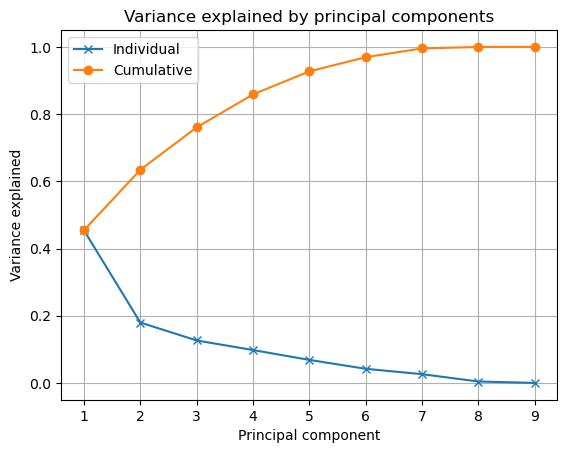

0.7606912558548665

In [12]:
print('cum sum: \n',np.cumsum(exp_var_ratio))

# Plot variance explained
plt.figure()
plt.plot(range(1, len(exp_var_ratio)+1), exp_var_ratio, 'x-')
plt.plot(range(1, len(exp_var_ratio)+1), np.cumsum(exp_var_ratio), 'o-')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative'])
plt.grid()
plt.show()

np.cumsum(exp_var_ratio)[2]

In [13]:
x[0,1]       # first value of sodium

0.03490970416695956

## Affine Transformation

In [14]:
def rotation_matrix(pitch, roll, yaw):
    # input in radians
    Rx = np.array([[1, 0, 0, 0], 
                   [0, np.cos(pitch), -np.sin(pitch), 0],
                   [0, np.sin(pitch), np.cos(pitch), 0], 
                   [0, 0, 0, 1]])
    Ry = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                   [0, 1, 0, 0], 
                   [-np.sin(roll), 0, np.cos(roll), 0], 
                   [0, 0, 0, 1]])
    Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0, 0,],
                   [np.sin(yaw), np.cos(yaw), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    R = np.dot(np.dot(Rx, Ry), Rz)
    return R

In [15]:
roll_rotation = rotation_matrix(0,np.deg2rad(30),0)
yaw_rotation = rotation_matrix(0,0,np.deg2rad(10))
translation = np.array([[1, 0, 0, 10], 
                        [0, 1, 0, 0],
                        [0, 0, 1, 0], 
                        [0, 0, 0, 1]])

In [16]:
yaw_rotation@translation@roll_rotation@np.eye(4)

array([[ 0.85286853, -0.17364818,  0.49240388,  9.84807753],
       [ 0.15038373,  0.98480775,  0.08682409,  1.73648178],
       [-0.5       ,  0.        ,  0.8660254 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

## Box

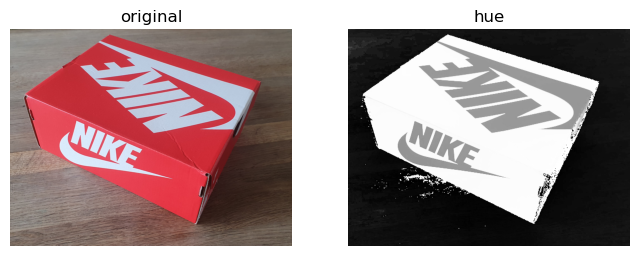

In [17]:
input_img = io.imread(in_dir + "nike.png")

hsv_img = color.rgb2hsv(input_img)
hue_img = hsv_img[:,:,0]

plot_comparison(input_img, hue_img, "hue")

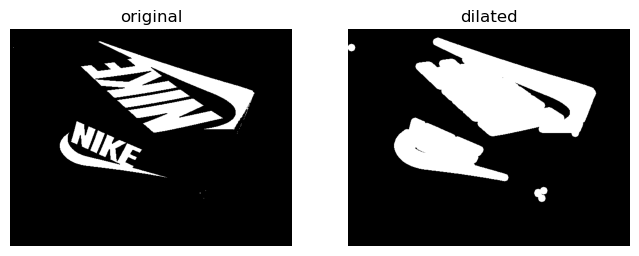

In [18]:
segm = (hue_img > 0.3) & (hue_img < 0.7)
dilated = dilation(segm,disk(8))
plot_comparison(segm, dilated, "dilated")

In [19]:
dilated.sum()

58979

## FPS Video Surveillance

In [20]:
n_btyes_per_image = 1600*800*3
n_megabytes_per_s = n_btyes_per_image*6.25/1e6
n_megabytes_per_s

24.0

In [21]:
n_algo = 1/230e-3
print(f"algo FPS: {n_algo}")
print(f'system FPS: {min(n_algo,6.25)}')

algo FPS: 4.3478260869565215
system FPS: 4.3478260869565215


## Shoe comparison

In [22]:
src = np.array([(40, 320), (425, 120), (740, 330)])  # shoe1
dst = np.array([(80, 320), (380, 155), (670, 300)])  # shoe2

tform = SimilarityTransform()
tform.estimate(src, dst)
# tform.estimate(shoe1_lm, shoe2_lm)

True

In [23]:
src_transform = matrix_transform(src, tform.params)

e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)

e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)

F_before = error_x + error_y
print(f"F_before: {F_before}")

e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)

e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)

F_after = error_x + error_y
print(f"F_after: {F_after}")

print(f"Change: {F_before-F_after}")

F_before: 10650
F_after: 373.01770826994596
Change: 10276.982291730053


In [24]:
tform.scale

0.8327055808649095

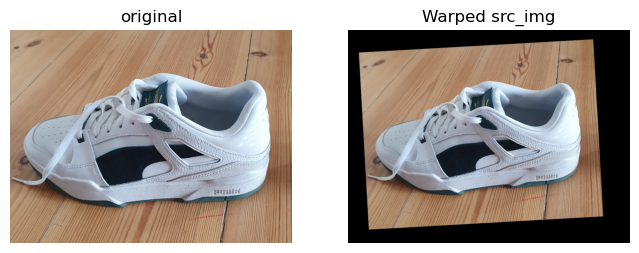

In [25]:
src_img = io.imread(in_dir + 'shoe_1.png')
dst_img = io.imread(in_dir + 'shoe_2.png')

warped = warp(src_img, tform.inverse)
plot_comparison(src_img, warped, "Warped src_img")
ubyte_warped = img_as_ubyte(warped)
ubyte_dst = img_as_ubyte(dst_img)

In [26]:
ubyte_warped[200,200,2]

113

In [27]:
ubyte_dst[200,200][2]

139

In [28]:
139-113

26

## Character recognition

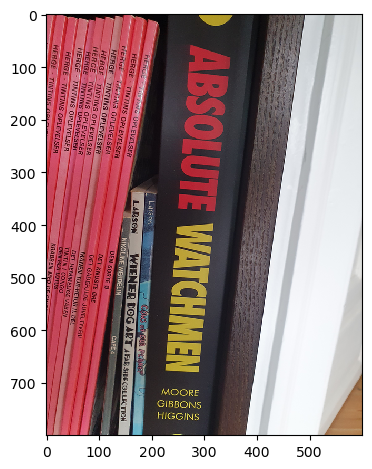

In [29]:
input_img = io.imread(in_dir + "Letters.png")
io.imshow(input_img)
io.show()

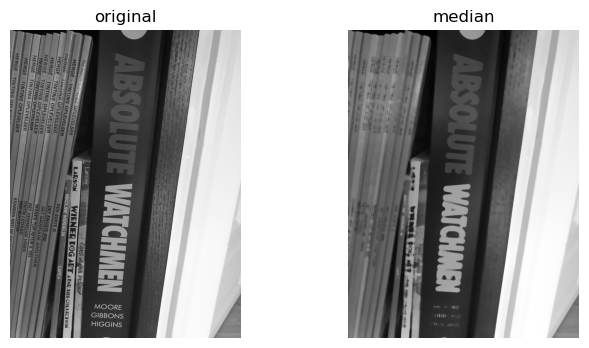

0.44944431372549015

In [30]:
gray_img = rgb2gray(input_img)

size = 8
footprint = np.ones([size, size])
med_img = median(gray_img, footprint)

plot_comparison(gray_img,med_img,'median')
med_img[100,100]

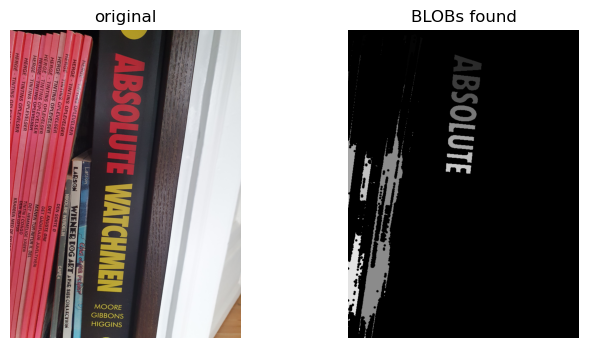

In [31]:
r_comp = input_img[:, :, 0]
g_comp = input_img[:, :, 1]
b_comp = input_img[:, :, 2]
segm = (r_comp > 100) & (g_comp < 100) & (b_comp < 100)

eroded = erosion(segm,disk(3))
label_img = measure.label(eroded)
region_props = measure.regionprops(label_img)

plot_comparison(input_img, label_img, 'BLOBs found')

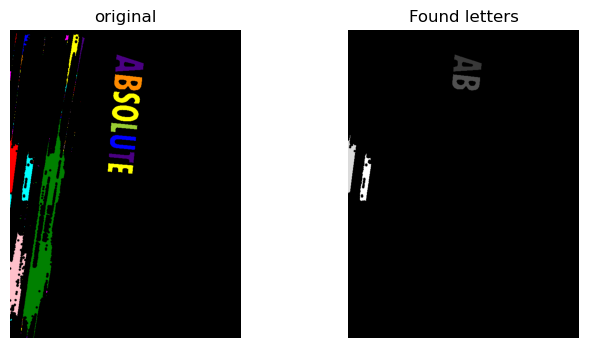

In [32]:
rgblabel_img = label2rgb(label_img)

# Create a copy of the label_img
label_img_filter = np.copy(label_img)
for region in region_props:
    if region.area < 1000 or region.area > 4000 or region.perimeter < 300:
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
            
plot_comparison(rgblabel_img, label_img_filter, 'Found letters')

36073


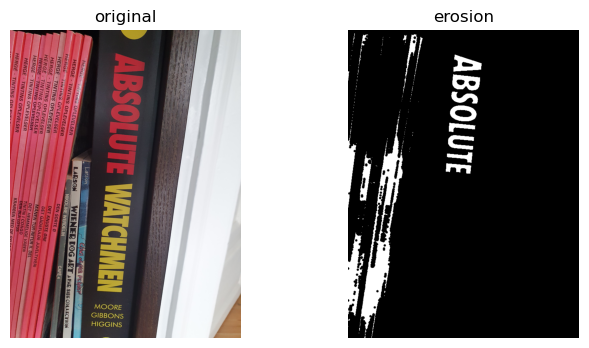

In [33]:
r_comp = input_img[:, :, 0]
g_comp = input_img[:, :, 1]
b_comp = input_img[:, :, 2]
segm = (r_comp > 100) & (g_comp < 100) & (b_comp < 100)

eroded = erosion(segm,disk(3))
print(eroded.sum())

plot_comparison(input_img, eroded, 'erosion')

## Abdominal CT Analysis

In [34]:
ct = dicom.read_file(in_dir + '1-166.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


In [35]:
ROI = ['LiverROI', 'KidneyRoi_l', 'KidneyRoi_r']
mu_organs = []
std_organs = []
for roi in ROI:
    roi_img = io.imread(in_dir + roi + '.png')
    organ_mask = roi_img > 0
    organ_values = img[organ_mask]
    mu_organ = np.mean(organ_values)
    std_organ = np.std(organ_values)
    mu_organs.append(mu_organ)
    std_organs.append(std_organ)

In [36]:
print(f'avg left kidney: {mu_organs[1]}')
print(f'avg right kidney: {mu_organs[2]}')

avg left kidney: 107.45075421472937
avg right kidney: 107.56182572614108


In [37]:
print(f'avg liver: {mu_organs[0]}')
print(f'std liver: {std_organs[0]}')

avg liver: 76.33393774554246
std liver: 24.53705543438126


In [38]:
t_1 = mu_organs[0] - std_organs[0]
t_2 = mu_organs[0] + std_organs[0]
print(t_1,t_2)

51.7968823111612 100.87099317992372


In [39]:
segm = (img>t_1) & (img<t_2)
dilated = dilation(segm,disk(3))
eroded = erosion(dilated,disk(10))
dilated_2 = dilation(eroded,disk(10))

label_img = measure.label(dilated_2)
region_props = measure.regionprops(label_img)
rgblabel_img = label2rgb(label_img)

label_img.shape

(512, 512)

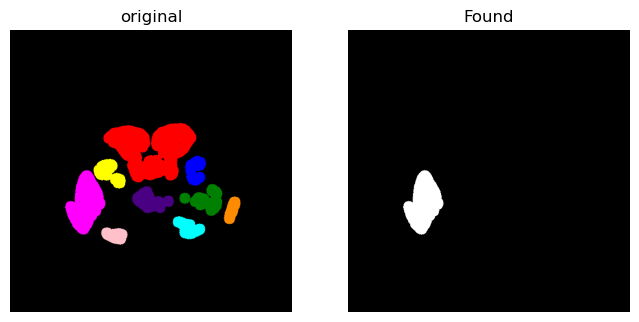

In [40]:
# Create a copy of the label_img
label_img_filter = np.copy(label_img)
for region in region_props:
    if region.area < 1500 or region.area > 7000 or region.perimeter < 300:
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
            
plot_comparison(rgblabel_img, label_img_filter, 'Found')

In [41]:
ref_img = io.imread(in_dir+'LiverROI.png')

liver_roi = ref_img > 0
liver_estimate = label_img_filter > 0

dice_score = 1 - distance.dice(liver_estimate.ravel(), liver_roi.ravel())
dice_score

0.782588123964987

## Video change detection

In [42]:
new_frame = io.imread(in_dir+'new_frame.png')
background = io.imread(in_dir+'background.png')

gray_new = rgb2gray(new_frame)
gray_bg = rgb2gray(background)

alpha = 0.90
new_gray_bg = alpha * gray_bg + (1-alpha) * gray_new

abs_img = abs(gray_new-new_gray_bg)
thresholded = abs_img > 0.1
thresholded.sum()

25764

In [43]:
new_gray_bg[150:200,150:200].mean()

0.602417740972549

## Pizza PCA

In [44]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [45]:
raw_dir = in_dir + "training/"

# exercise 2: compute data matrix
all_images = glob.glob(raw_dir + "*.png")  # make list of path to all images
n_samples = len(all_images)

# read first image
first_img = io.imread(all_images[0])
height, width, channels = first_img.shape
n_features = height*width*channels

print("n_samples: ", n_samples)
print("n_features: ", n_features)

data_matrix = np.zeros((n_samples, n_features))
for idx,img_path in enumerate(all_images):
    img = io.imread(img_path)
    data_matrix[idx,:] = img.flatten()

n_samples:  10
n_features:  270000


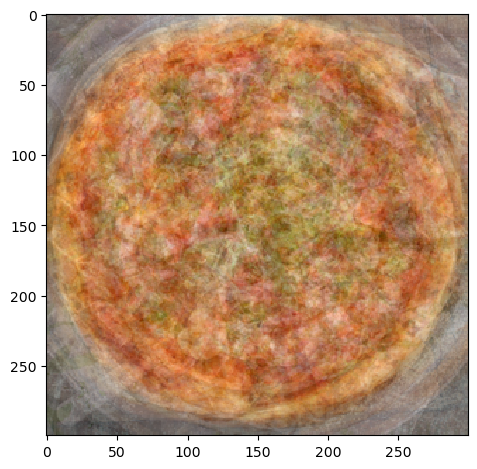

In [46]:
avg_piz = np.mean(data_matrix,axis=0)
avg_piz_img = create_u_byte_image_from_vector(avg_piz, height, width, channels)

io.imshow(avg_piz_img)
io.show()

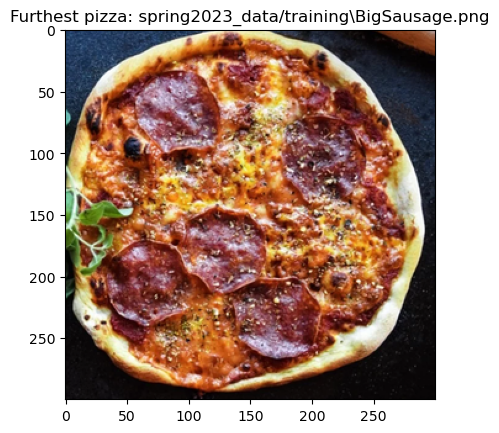

In [47]:
sub_data = data_matrix - avg_piz
sub_distances = np.linalg.norm(sub_data, axis=1)

# find training pizza with largest SSD
piz_idx = np.argmax(sub_distances)

im_closest = io.imread(all_images[piz_idx])
plt.imshow(im_closest)
plt.title(f'Furthest pizza: {all_images[piz_idx]}')
plt.show()

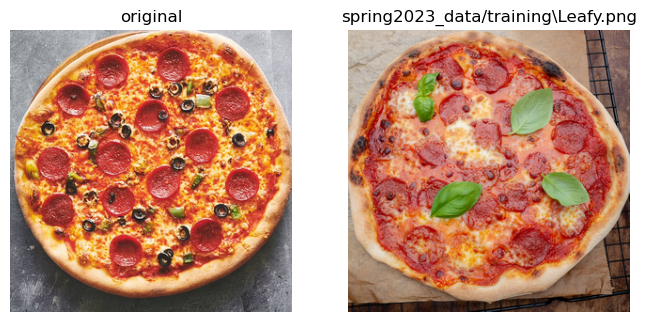

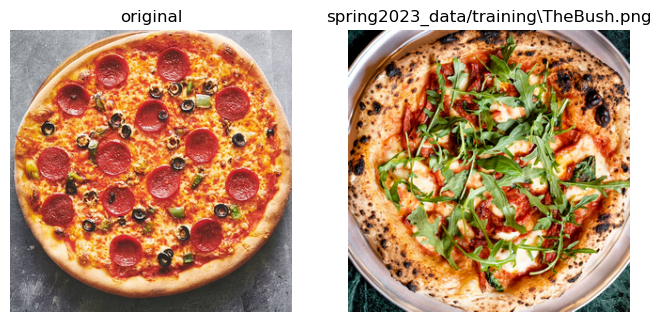

In [48]:
im_super = io.imread(in_dir + 'super_pizza.png')
sub_data = data_matrix - im_super.flatten()
sub_distances = np.linalg.norm(sub_data, axis=1)

# find training pizza based on SSD
min_piz_idx = np.argmin(sub_distances)
max_piz_idx = np.argmax(sub_distances)

im_closest = io.imread(all_images[min_piz_idx])
im_furthest = io.imread(all_images[max_piz_idx])

im_closest = io.imread(all_images[min_piz_idx])
plot_comparison(im_super,im_closest,f'{all_images[min_piz_idx]}')
plot_comparison(im_super,im_furthest,f'{all_images[max_piz_idx]}')

In [49]:
pca = decomposition.PCA()
pca.fit(data_matrix)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_
data_transform = pca.transform(data_matrix)

In [50]:
data_transform.shape

(10, 10)

[  715.39678552  7720.16831057 -2326.59780609   774.43136773
  -211.5134645  -3536.22517562 -1406.87164359   899.36159407
  2611.31897672   -25.18323278]
5


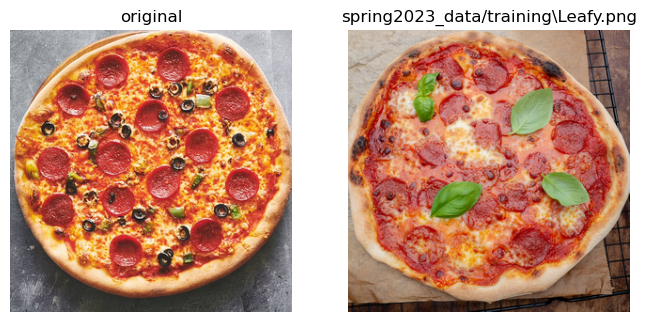

In [51]:
im_super = io.imread(in_dir + 'super_pizza.png')

im_super_flat = im_super.flatten()
im_super_flat = im_super_flat.reshape(1, -1)
pca_coords = pca.transform(im_super_flat)
pca_coords = pca_coords.flatten()
print(pca_coords)

comp_sub = data_transform - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
min_piz_idx = np.argmin(pca_distances)
print(min_piz_idx)

im_closest = io.imread(all_images[min_piz_idx])
plot_comparison(im_super,im_closest,f'{all_images[min_piz_idx]}')

In [52]:
pc_1 = data_transform[:, 0]
pc_2 = data_transform[:, 1]

min_piz1 = np.argmin(pc_1)
max_piz1 = np.argmax(pc_1)
print(f'min: {all_images[min_piz1]}')
print(f'max: {all_images[max_piz1]}')

min: spring2023_data/training\FindTheOlives.png
max: spring2023_data/training\BigSausage.png


individual var: 
 [2.30827870e-01 1.39333540e-01 1.23203512e-01 1.13331183e-01
 1.07139352e-01 8.88582289e-02 7.61708365e-02 6.73516980e-02
 5.37837793e-02 1.07438130e-29]


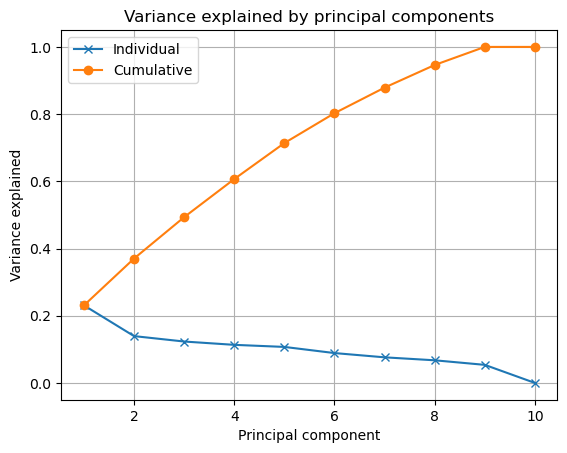

In [53]:
print('individual var: \n',exp_var_ratio)

# Plot variance explained
plt.figure()
plt.plot(range(1, len(exp_var_ratio)+1), exp_var_ratio, 'x-')
plt.plot(range(1, len(exp_var_ratio)+1), np.cumsum(exp_var_ratio), 'o-')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative'])
plt.grid()
plt.show()

## Concert light design

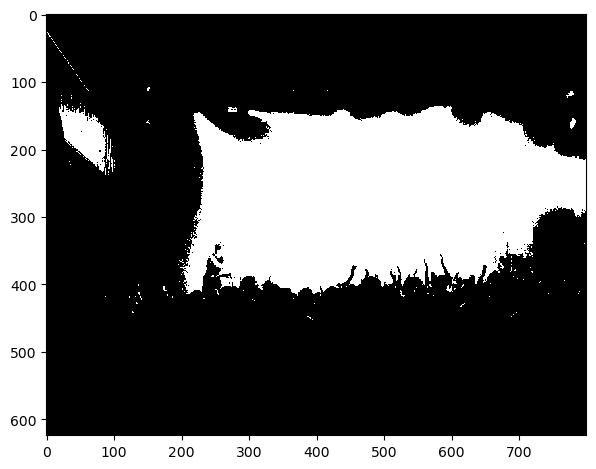

Otsu threshold:  0.419921875


In [54]:
input_img = io.imread(in_dir + 'lights.png')
rot_center = [40, 40]
rotation_angle = 11
rotated_img = rotate(input_img, rotation_angle, center=rot_center)

gray_img = rgb2gray(rotated_img)
otsu_thres = threshold_otsu(gray_img)
bin_img = gray_img > otsu_thres
io.imshow(bin_img)
io.show()
print("Otsu threshold: ", otsu_thres)

In [55]:
count = np.bincount(bin_img.flatten())
count[1]/(count.sum())

0.2579967948717949